In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# --- Load all our saved artifacts ---
MODEL_PATH = '../models/multimodal_model.h5'
# UPDATED: Load both scaler files
FEATURE_SCALER_PATH = '../models/feature_scaler.pkl'
TARGET_SCALER_PATH = '../models/target_scaler.pkl'
DATA_PATH = '../data/processed/preprocessed_data.npz'

print("Loading model, scalers, and data...")
model = load_model(MODEL_PATH)
feature_scaler = joblib.load(FEATURE_SCALER_PATH)
target_scaler = joblib.load(TARGET_SCALER_PATH)
data = np.load(DATA_PATH, allow_pickle=True)

X_lstm = data['X_lstm']
X_mlp = data['X_mlp']
y = data['y']

print("Artifacts loaded successfully!")

Loading model, scalers, and data...
Artifacts loaded successfully!


In [5]:
# Recreate the exact same train/validation split to ensure we evaluate on unseen data
X_lstm_train, X_lstm_val, X_mlp_train, X_mlp_val, y_train, y_val = train_test_split(
    X_lstm, X_mlp, y, test_size=0.2, random_state=42
)

print("Making predictions on the validation set...")
# The model.predict() function returns the scaled predictions
scaled_predictions = model.predict([X_lstm_val, X_mlp_val])

Making predictions on the validation set...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# This is now much simpler and more robust using the dedicated target_scaler
print("Scaling predictions and true values back to their original units...")

unscaled_predictions = target_scaler.inverse_transform(scaled_predictions)
unscaled_y_val = target_scaler.inverse_transform(y_val)

# Separate the unscaled predictions for TG and GGT
predicted_tg = unscaled_predictions[:, 0]
predicted_ggt = unscaled_predictions[:, 1]
true_tg = unscaled_y_val[:, 0]
true_ggt = unscaled_y_val[:, 1]

print("Inverse transform complete.")

Scaling predictions and true values back to their original units...
Inverse transform complete.


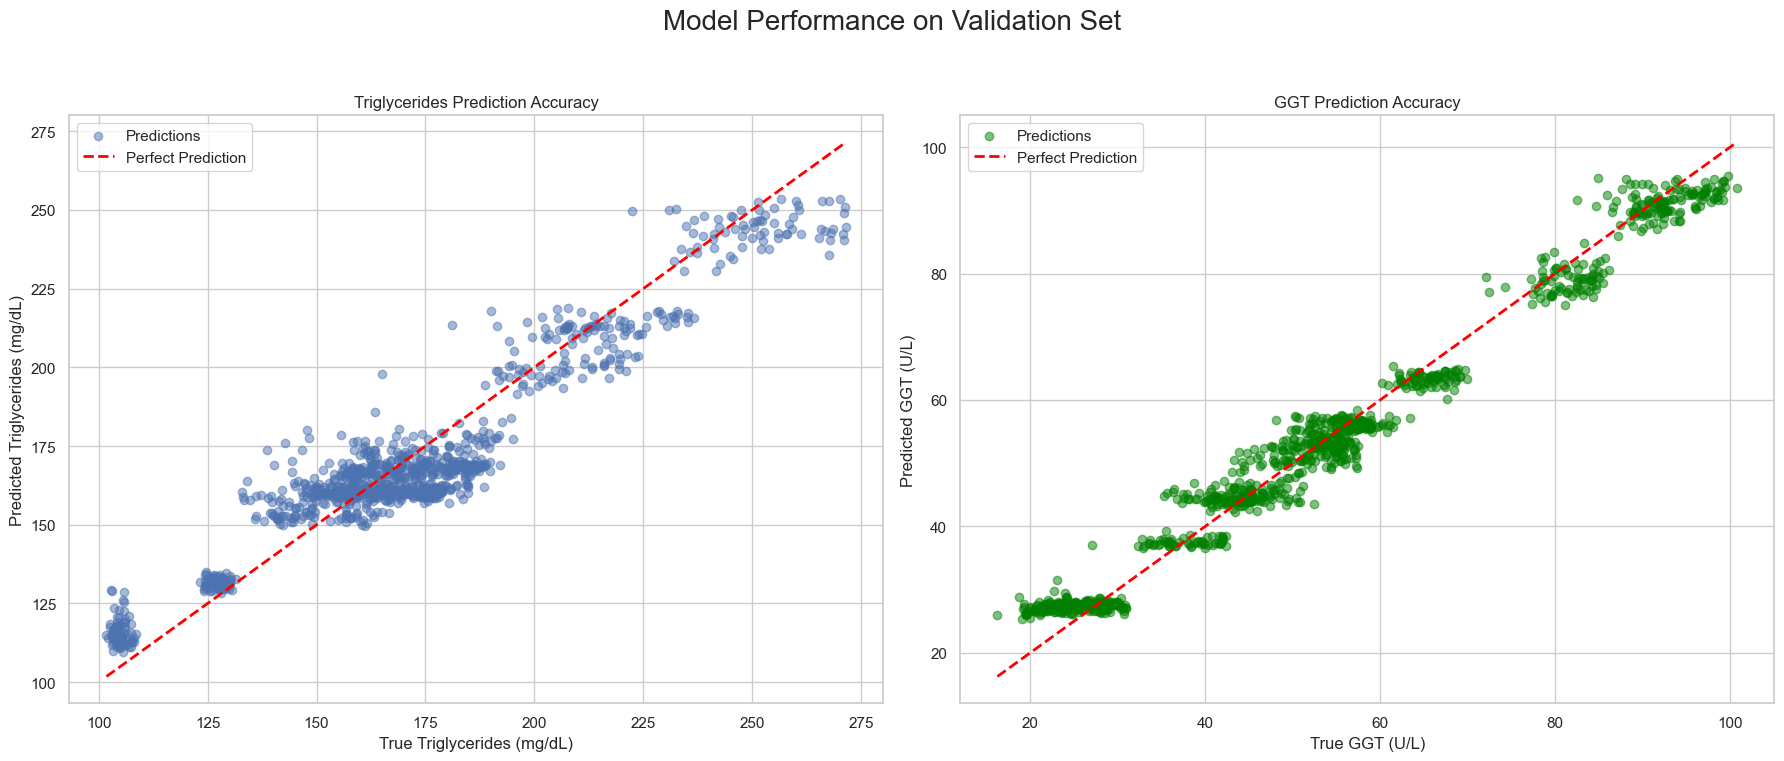

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Model Performance on Validation Set', fontsize=20)

# Scatter plot for Triglycerides
axes[0].scatter(true_tg, predicted_tg, alpha=0.5, label='Predictions')
axes[0].plot([min(true_tg), max(true_tg)], [min(true_tg), max(true_tg)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("True Triglycerides (mg/dL)")
axes[0].set_ylabel("Predicted Triglycerides (mg/dL)")
axes[0].set_title("Triglycerides Prediction Accuracy")
axes[0].legend()
axes[0].grid(True)

# Scatter plot for GGT
axes[1].scatter(true_ggt, predicted_ggt, alpha=0.5, label='Predictions', color='green')
axes[1].plot([min(true_ggt), max(true_ggt)], [min(true_ggt), max(true_ggt)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel("True GGT (U/L)")
axes[1].set_ylabel("Predicted GGT (U/L)")
axes[1].set_title("GGT Prediction Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()